# 导入相关包

In [1]:
import tensorflow as tf
import numpy as np
import math
import h5py
import keras
from keras.utils import np_utils
from keras import models
from keras.layers import InputLayer,Input,Reshape,MaxPooling2D,Conv2D,Dense,Flatten
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import backend as K

# 配置神经网络

In [2]:
#配置神经网络
img_size=28 #图像的每个维度中的像素数
img_size_flat=28*28#图像存储在一维矩阵中的总长度
img_shape=(28,28)#用来重塑图像的高度和宽度的元祖
img_shape_full=(28,28,1)#用来重塑图像的高度，宽度和深度的元祖
num_classes=10#类别数量
num_channels=1#图像的通道数

# 导入数据集

In [3]:
#载入数据
path='../input/mnist-numpy/mnist.npz'
f=np.load(path)
x_train,y_train=f['x_train'],f['y_train']
x_test,y_test=f['x_test'],f['y_test']
f.close()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# 绘制训练结果图像，错图分类图像函数

In [4]:
#绘制图像的辅助函数
def plot_images(images,cls_true,cls_pred=None):
    assert len(images)==len(cls_true)==9
    fig,axes=plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)

    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap="binary")
        if cls_pred is None:
            xlabel="True:{0}".format(cls_true[i])
        else:
            xlabel="True:{0},Pred:{1}".format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

#绘制错误分类图像的辅助函数
def plot_example_errors(cls_pred,correct):
    incorrect=(correct==False)
    images=x_test[incorrect]
    cls_pred=cls_pred[incorrect]
    cls_true=y_test[incorrect]
    plot_images(images=images[0:9],cls_true=cls_true[0:9],cls_pred=cls_pred[0:9])

# 序列模型

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1764)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

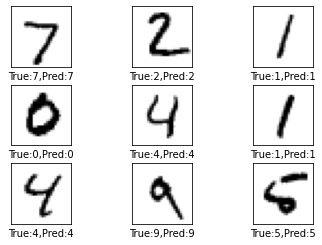

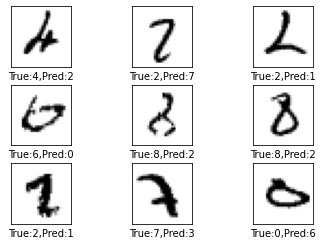

In [5]:
#序列模型
model=models.Sequential()
#添加一个输入层
model.add(InputLayer(input_shape=(img_size_flat,)))
#输入是一个包含784个元素的扁平数组，改变形状为（28，28，1）
model.add(Reshape(img_shape_full))
#具有Relu激活和最大池化的第一个卷积层
model.add(Conv2D(kernel_size=5,strides=1,filters=16,padding='same',activation='relu',name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2,strides=2))
#具有Relu激活和最大池化的第二个卷积层
model.add(Conv2D(kernel_size=5,strides=1,filters=36,padding='same',activation='relu',name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2,strides=2))
#将卷积层的4级输出为2级，可以输入到完全连接层
model.add(Flatten())
#具有Relu激活的第一个全连接层
model.add(Dense(128,activation='relu'))
#最后一个全连接层，具有softmax激活功能，用于分类
model.add(Dense(num_classes,activation='softmax'))
#编译模型
model.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
#训练模型
x_train=x_train.reshape(60000,784)#将图片摊平
x_test=x_test.reshape(10000,784)
#归一化
x_train=x_train/255
x_test=x_test/255
#one-hot编码
y_train=keras.utils.to_categorical(y_train,10)
y_test=keras.utils.to_categorical(y_test,10)
model.fit(x_train,y_train,epochs=1,batch_size=128,validation_split=1/12,verbose=2)
#评估与性能指标
result=model.evaluate(x_test,y_test,verbose=1)
print("loss",result[0])
print("acc",result[1])
#预测
predict=model.predict(x_test)
predict=np.argmax(predict,axis=1)
y_test=np.argmax(y_test,axis=1)
plot_images(x_test[0:9],y_test[0:9],predict[0:9])
#错分类的图片
y_pred=model.predict(x_test)
cls_pred=np.argmax(y_pred,axis=1)
correct=(cls_pred==y_test)
plot_example_errors(cls_pred,correct=correct)

# 功能模型

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1764)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

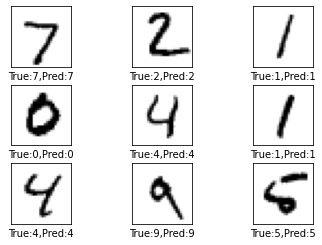

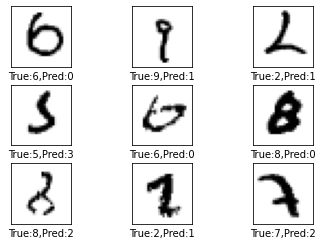

In [6]:
#功能模型
#创建一个输入层。
inputs=Input(shape=(img_size_flat,))
#用于构建神经网络的变量
net=inputs
#输入是一个包含784个元素的扁平数组
#改变形状
net=Reshape(img_shape_full)(net)
#具有relu激活和最大池化的第一个卷积层
net=Conv2D(kernel_size=5,strides=1,filters=16,padding='same',activation='relu',name='layer_conv1')(net)
net=MaxPooling2D(pool_size=2,strides=2)(net)
#具有Relu激活和最大池化的第二个卷积层
net=Conv2D(kernel_size=5,strides=1,filters=36,padding='same',activation='relu',name='layer_conv2')(net)
net=MaxPooling2D(pool_size=2,strides=2)(net)
#将卷积层的4级输出展平为2级，可以输入到全连接层
net=Flatten()(net)
#具有relu激活的第一个全连接层
net=Dense(128,activation='relu')(net)
#最后一个全连接层
net=Dense(num_classes,activation='softmax')(net)
#神经网络输出
outputs=net
#模型编译
model2=models.Model(inputs=inputs,outputs=outputs)
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
#训练
model2.fit(x_train,y_train,batch_size=128,epochs=1,validation_split=1/12,verbose=2)
y_test_h=keras.utils.to_categorical(y_test,10)
result=model2.evaluate(x_test,y_test_h,verbose=1)
print(model2.metrics_names[0],result[0])
print(model2.metrics_names[1],result[1])
#预测
predict=model2.predict(x_test)
predict=np.argmax(predict,axis=1)
plot_images(x_test[0:9],y_test[0:9],predict[0:9])
#错分类的照片
y_pred=model2.predict(x_test)
cls_pred=np.argmax(y_pred,axis=1)
correct=(cls_pred==y_test)
plot_example_errors(cls_pred,correct=correct)

# 保存加载模型

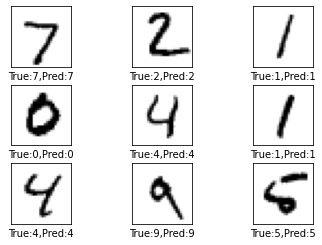

In [7]:
#保存模型
path_model="../output/model2.pkl"
model2.save(path_model)
#删除模型
del model2
#加载模型3
model3=models.load_model(path_model)
#模型3预测
predict=model3.predict(x_test)
predict=np.argmax(predict,axis=1)
plot_images(x_test[0:9],y_test[0:9],predict[0:9])

# 画卷积权重的辅助函数 画卷积层输出的辅助函数

In [8]:
#卷积权重的辅助函数
def plot_conv_weights(weights,input_channel=0):
    #获取权重的最高、低值
    #这用于矫正图像的颜色强度
    w_min=np.min(weights)
    w_max=np.max(weights)
    #卷积层中的卷积核数量
    num_filters=weights.shape[3]
    #要绘制的网格数
    #卷积核的平方根
    num_grids=math.ceil(math.sqrt(num_filters))
    #创建带有网格子图的图像
    fig,axes=plt.subplots(num_grids,num_grids)
    #画出所有卷积核的输出图像
    for i,ax in enumerate(axes.flat):
     #仅画出有效卷积核图像
        if i<num_filters:
            #获取第i个卷积核的输出图像
            img=weights[:,:,input_channel,i]
            #画图
            ax.imshow(img,vmin=w_min,vmax=w_max,interpolation='nearest',cmap='seismic')
        #溢出刻度线
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
#卷积层输出的帮助函数
def plot_conv_output(values):
    #卷积层中的卷积核数量
    num_filters=values.shape[3]
    #要绘制的网格数
    #卷积核的平方根
    num_grids=math.ceil(math.sqrt(num_filters))
    #创建带有网格子图的图像
    fig,axes=plt.subplots(num_grids,num_grids)
    #画出所有卷积核的输出图像
    for i,ax in enumerate(axes.flat):
        #仅画出有效卷积核图像
        if i<num_filters:
            #获取第i个卷积核的输出图像
            img=values[0,:,:,i]
            #画图
            ax.imshow(img,interpolation='nearest',cmap='binary')
        #溢出刻度线
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
#输入图像
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
              interpolation='nearest',cmap='binary')
    plt.show()

# 输出各卷积层的输出图像

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)             

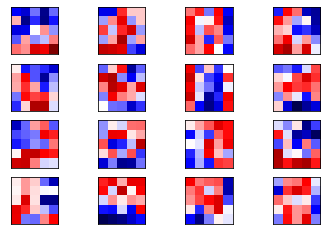

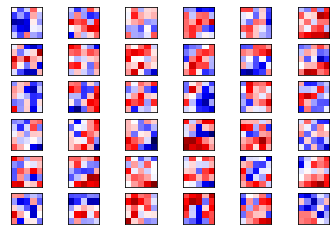

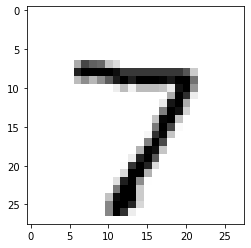

(1, 28, 28, 16)


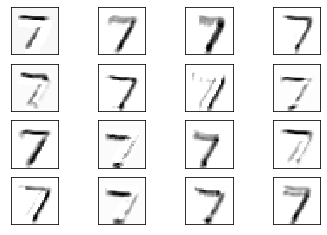

(1, 14, 14, 36)


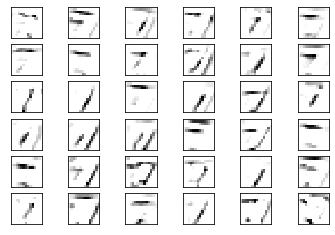

In [9]:
#得到层
model3.summary()
layer_input=model3.layers[0]
layer_conv1=model3.layers[2]
layer_conv2=model3.layers[4]
#卷积权重
weights_conv1=layer_conv1.get_weights()[0]
plot_conv_weights(weights=weights_conv1,input_channel=0)
weights_conv2=layer_conv2.get_weights()[0]
plot_conv_weights(weights=weights_conv2,input_channel=0)
#输入图像
image1=x_test[0]
plot_image(image1)
#卷积层输出一
output_conv1=K.function(inputs=[layer_input.input],outputs=[layer_conv1.output])
layer_output1=output_conv1(np.array([image1]))[0]
print(layer_output1.shape)
plot_conv_output(values=layer_output1)
#卷积层输出二
output_conv2=models.Model(inputs=layer_input.input,outputs=layer_conv2.output)
layer_output2=output_conv2(np.array([image1]))
print(layer_output2.shape)
plot_conv_output(values=layer_output2)
